# Imports

In [ ]:
import os
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer's Relu etc. 
from torch.utils.data import Dataset, DataLoader # Preprocessing Dataset, Loading Dataset

from PIL import Image # Open Image
import torchvision.transforms as transforms # Image Processing & Augmentation i.e. Resize, Flip, Normalize etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # Measures Similarity Between Vectors 

# Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Compute Unified Device Architecture 
print(device)
# CUDA is NVIDIA’s platform that lets programmers use the GPU for general-purpose computing.

# Image Transforms

In [ ]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # [0,1]
])


# LOAD & EXPLORE DATASET
## Custom Dataset (No Labels) 

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# LOAD DATASET

In [ ]:
IMAGE_DIR = "/kaggle/input/product-images-dataset/small/01"

dataset = ImageDataset(IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# VISUALIZE RANDOM IMAGES (SANITY CHECK)

In [ ]:
images = next(iter(dataloader))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis("off")
plt.show()


# DEFINE CNN AUTOENCODER (FROM SCRATCH)
## Encoder (Feature Extractor)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128)   # embedding vector
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


## Decoder (For Reconstruction)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 128 * 16 * 16),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x


## Autoencoder Wrapper

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


# INITIALIZE MODEL

In [ ]:
model = Autoencoder().to(device)


# LOSS & OPTIMIZER

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN THE AUTOENCODER

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")


# EXTRACT PRODUCT EMBEDDINGS

In [ ]:
model.eval()

embeddings = []
image_names = dataset.image_files

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)


# PROCESS USER-UPLOADED IMAGE

In [ ]:
def process_query_image(path):
    image = Image.open(path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image


In [ ]:
query_image = process_query_image("/kaggle/input/product-images-dataset/small/01/01013f05.jpg")

In [ ]:
img = Image.open("/kaggle/input/product-images-dataset/small/01/01013f05.jpg").convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

# COMPUTE SIMILARITY

In [ ]:
with torch.no_grad():
    query_embedding = model.encoder(query_image).cpu().numpy()


In [ ]:
similarity = cosine_similarity(query_embedding, embeddings)

# TOP-N RECOMMENDATIONS

In [ ]:
TOP_N = 5
top_indices = similarity[0].argsort()[-TOP_N:][::-1]


# SHOW RECOMMENDED IMAGES

In [ ]:
plt.figure(figsize=(15,5))

for i, idx in enumerate(top_indices):
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = Image.open(img_path)

    plt.subplot(1, TOP_N, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()


# Exploring Fashion Product Images Dataset

In [2]:
import os
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer's Relu etc. 
from torch.utils.data import Dataset, DataLoader # Preprocessing Dataset, Loading Dataset

from PIL import Image # Open Image
import torchvision.transforms as transforms # Image Processing & Augmentation i.e. Resize, Flip, Normalize etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # Measures Similarity Between Vectors 
import pandas as pd
import seaborn as sns

In [3]:
df_images = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv')
df_styles = pd.read_csv(
    '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv',
    on_bad_lines='skip',
    encoding='utf-8'
)

In [4]:
df_styles.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [5]:
df_styles['masterCategory']

0              Apparel
1              Apparel
2          Accessories
3              Apparel
4              Apparel
             ...      
44419         Footwear
44420         Footwear
44421          Apparel
44422    Personal Care
44423      Accessories
Name: masterCategory, Length: 44424, dtype: object

In [6]:
df_styles['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [7]:
df_styles['masterCategory']
df_masterCategory_OnlyApparel = df_styles[df_styles['masterCategory']=='Apparel']

In [8]:
df_masterCategory_OnlyApparel

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
...,...,...,...,...,...,...,...,...,...,...
44414,30614,Men,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Sports,Nike Men Striped Black Jersey
44415,13496,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts
44417,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top


In [9]:
df_masterCategory_OnlyApparel['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Innerwear', 'Saree', 'Dress',
       'Loungewear and Nightwear', 'Apparel Set', 'Socks'], dtype=object)

In [10]:
# df_masterCategory_OnlyApparel['subCategory'] == df_styles['Bottomwear']
df_subCategory_OnlyApparel_Bottomwear = df_masterCategory_OnlyApparel['subCategory']

In [11]:
df_styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [12]:
df_updated_styles = df_styles[df_styles['gender'].isin(['Men', 'Women'])]
df_updated_styles

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [13]:
df_images.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [14]:
df_images.columns

Index(['filename', 'link'], dtype='object')

In [15]:
# Quick overview
print("Number of products in styles.csv:", len(df_styles))
print("Number of images in images.csv:", len(df_images))

Number of products in styles.csv: 44424
Number of images in images.csv: 44446


In [16]:
print("Styles CSV Shape", df_styles.shape)
print("Images CSV Shape", df_images.shape)

Styles CSV Shape (44424, 10)
Images CSV Shape (44446, 2)


# Exploratory Data Analysis

In [17]:
total_products = df_styles['id'].nunique()
print("Total unique products:", total_products)


Total unique products: 44424


# Merging Image with Meta Data

In [18]:
# Total images
df = df_styles
print("Total images:", len(df))

# Number of unique categories
print("Master categories:", df['masterCategory'].nunique())
print("Subcategories:", df['subCategory'].nunique())
print("Article types:", df['articleType'].nunique())
print("Colors:", df['baseColour'].nunique())


Total images: 44424
Master categories: 7
Subcategories: 45
Article types: 143
Colors: 46


# Class Distribution (Master Category)

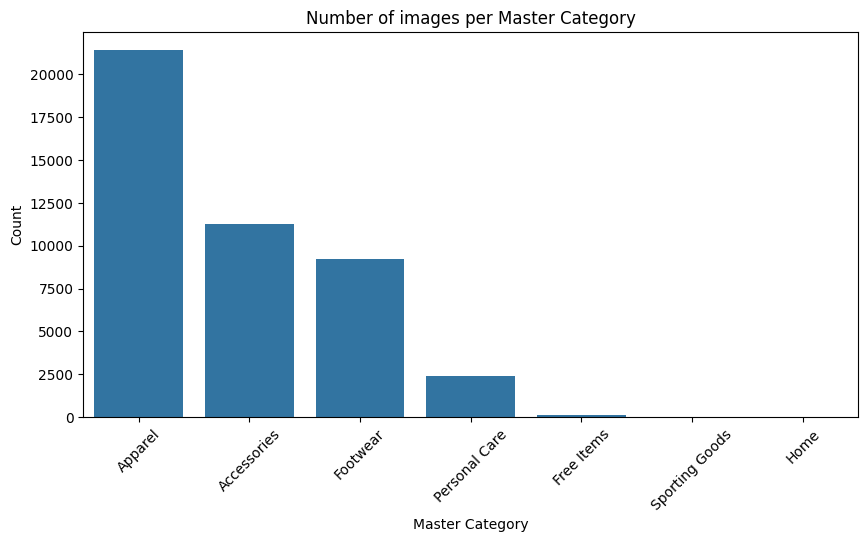

In [19]:
# Count images per masterCategory
category_counts = df['masterCategory'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Number of images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()

# Subcategory Distribution

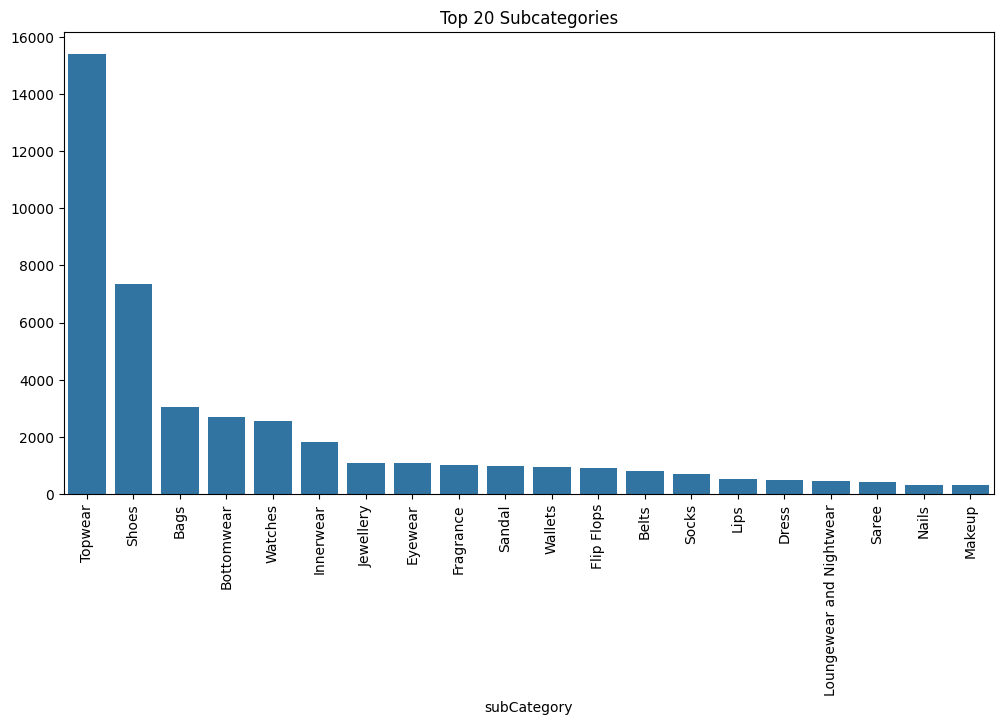

In [20]:
# Top 20 subcategories
sub_counts = df['subCategory'].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=sub_counts.index, y=sub_counts.values)
plt.title("Top 20 Subcategories")
plt.xticks(rotation=90)
plt.show()

# Color distribution

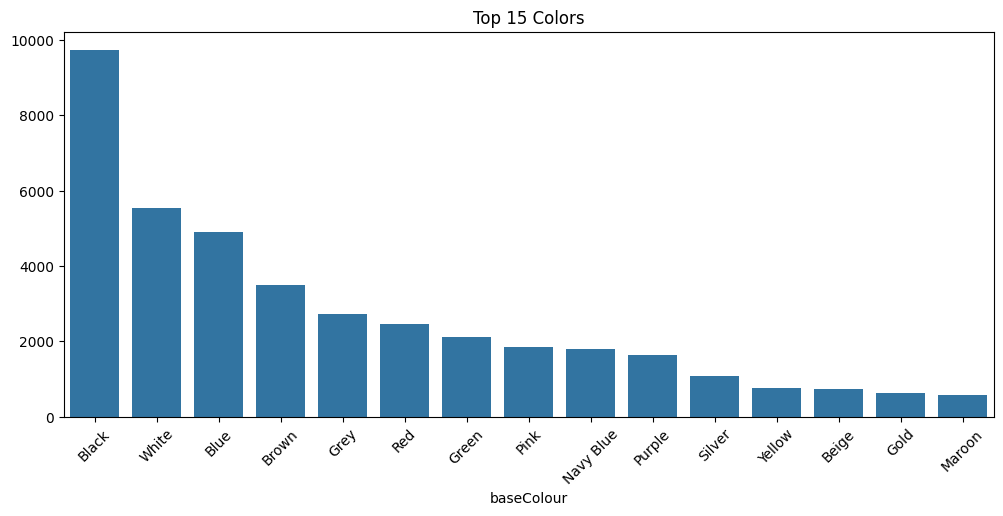

In [21]:
color_counts = df['baseColour'].value_counts().head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=color_counts.index, y=color_counts.values)
plt.title("Top 15 Colors")
plt.xticks(rotation=45)
plt.show()


# Number of Images Per Master Category

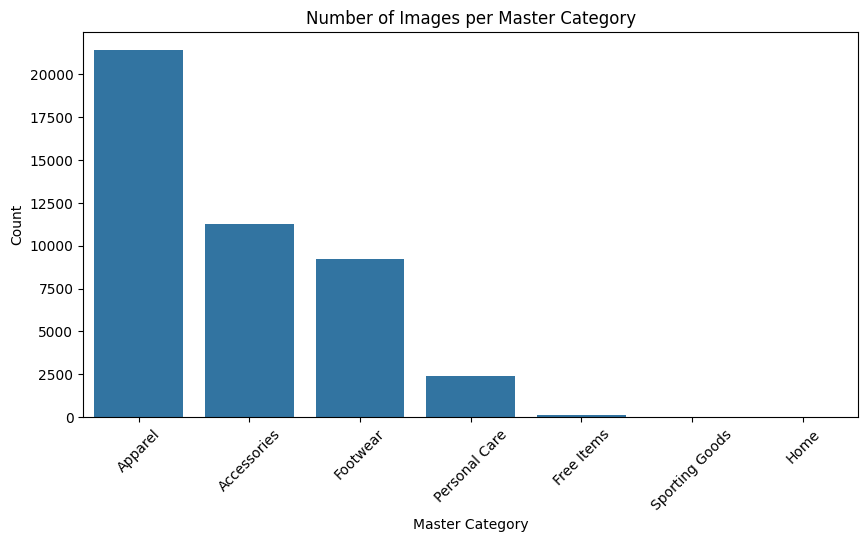

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='masterCategory', order=df['masterCategory'].value_counts().index)
plt.title("Number of Images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()


# Number of Images per sub category

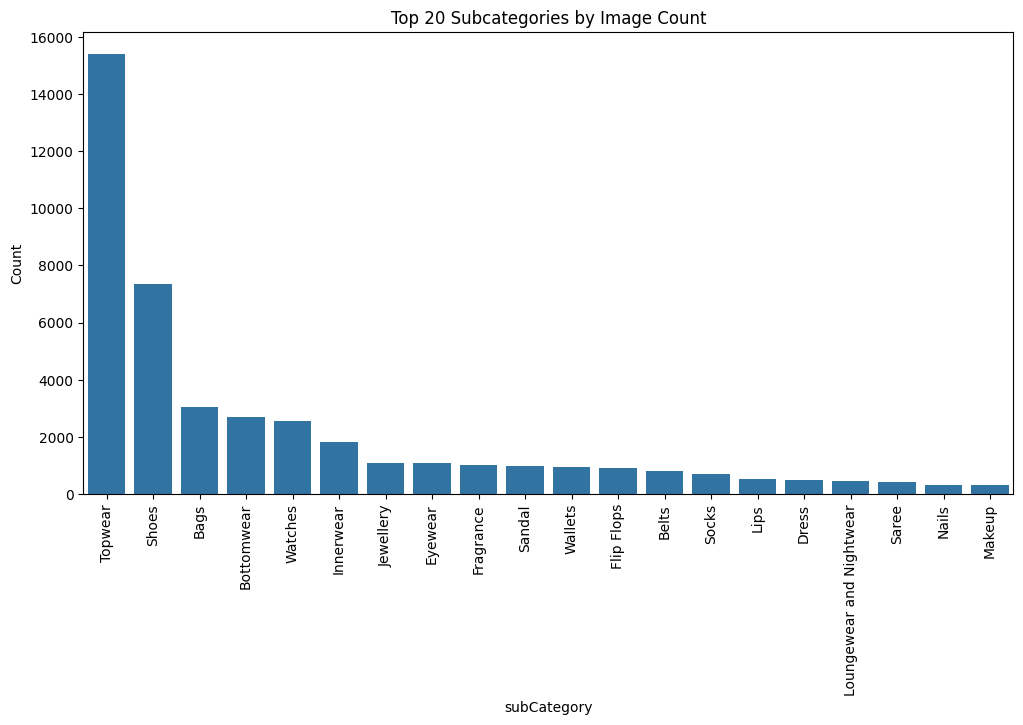

In [23]:
top_subcategories = df['subCategory'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_subcategories.index, y=top_subcategories.values)
plt.title("Top 20 Subcategories by Image Count")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# Color distribution (top 15)

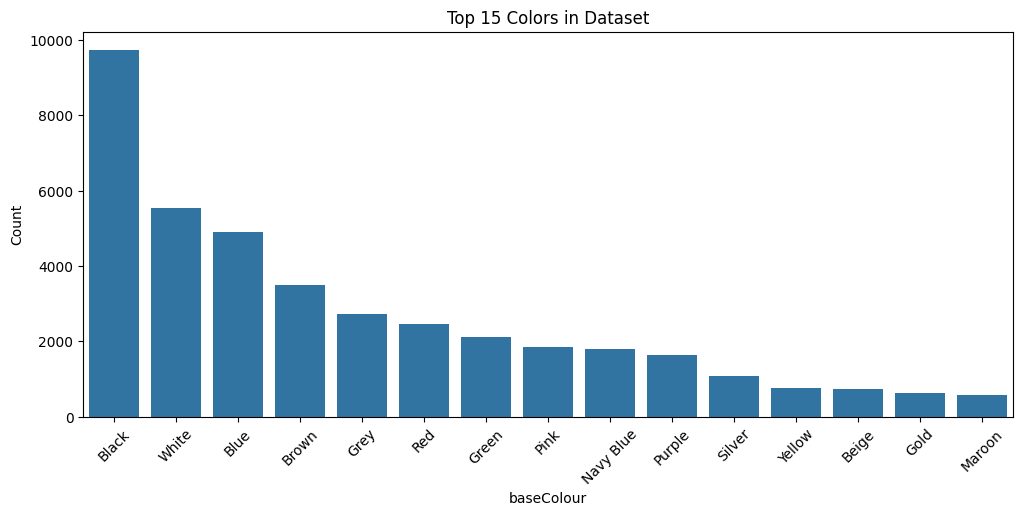

In [24]:
top_colors = df['baseColour'].value_counts().head(15)
plt.figure(figsize=(12,5))
sns.barplot(x=top_colors.index, y=top_colors.values)
plt.title("Top 15 Colors in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


# Images per gender

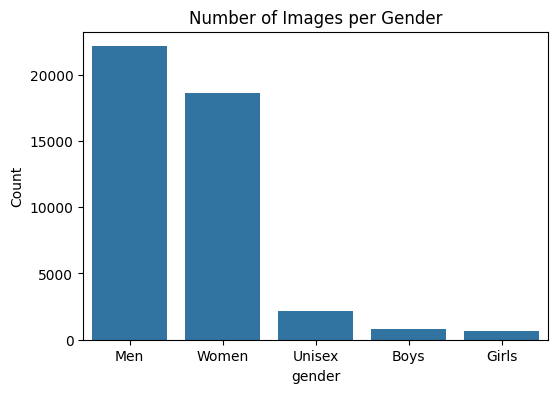

In [25]:
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Number of Images per Gender")
plt.ylabel("Count")
plt.show()


# Category vs. Gender Heatmap

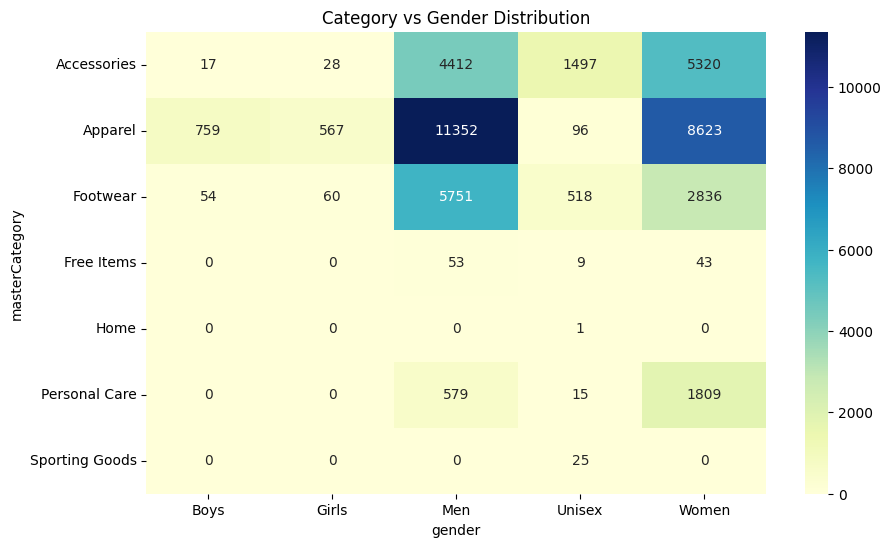

In [26]:
category_gender = pd.crosstab(df['masterCategory'], df['gender'])
plt.figure(figsize=(10,6))
sns.heatmap(category_gender, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Category vs Gender Distribution")
plt.show()


# Subcategory vs. Color Heatmap (top 20 subcategories)

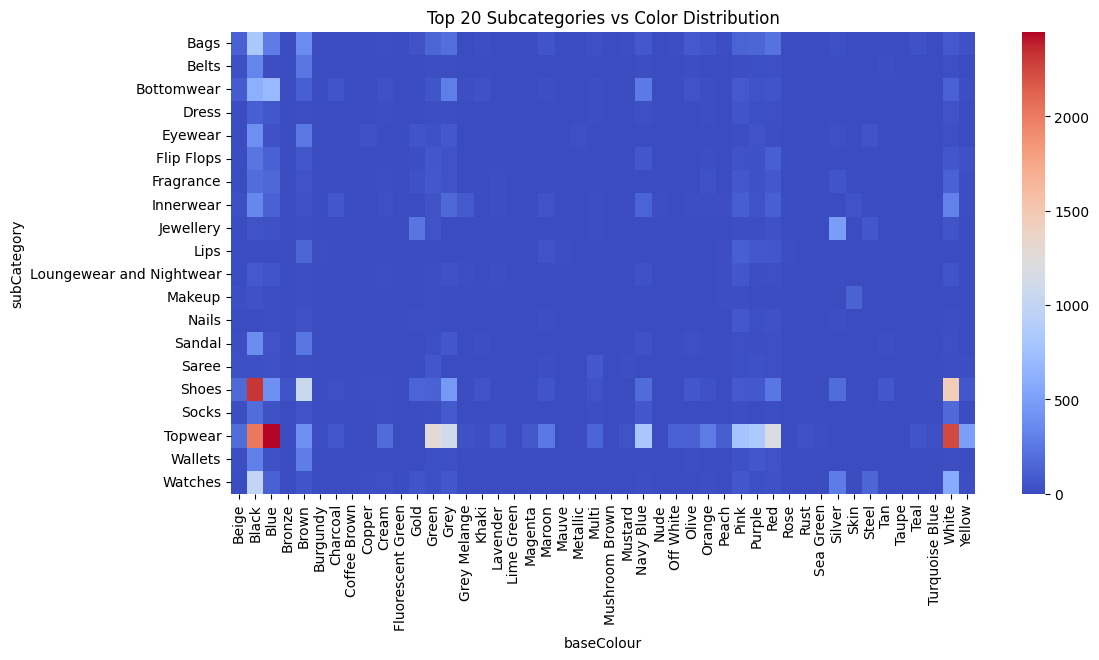

In [27]:
top_subs = df['subCategory'].value_counts().head(20).index
df_top = df[df['subCategory'].isin(top_subs)]

sub_color = pd.crosstab(df_top['subCategory'], df_top['baseColour'])
plt.figure(figsize=(12,6))
sns.heatmap(sub_color, cmap="coolwarm", annot=False)
plt.title("Top 20 Subcategories vs Color Distribution")
plt.show()


In [28]:
subcategory_counts = df_styles['subCategory'].value_counts()
subcategory_counts.head(10)


subCategory
Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Name: count, dtype: int64

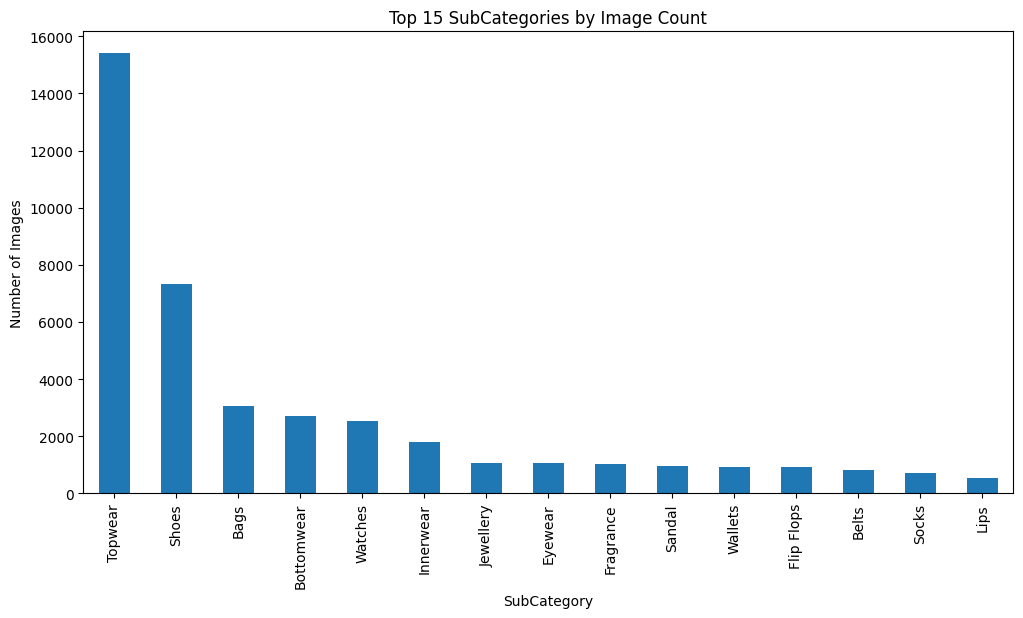

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
subcategory_counts[:15].plot(kind='bar')
plt.title("Top 15 SubCategories by Image Count")
plt.ylabel("Number of Images")
plt.xlabel("SubCategory")
plt.show()


# Filter Top Wear

In [30]:
topwear_df = df_styles[df_styles['subCategory'] == 'Topwear'].reset_index(drop=True)

print("Topwear images:", topwear_df.shape[0])


Topwear images: 15402


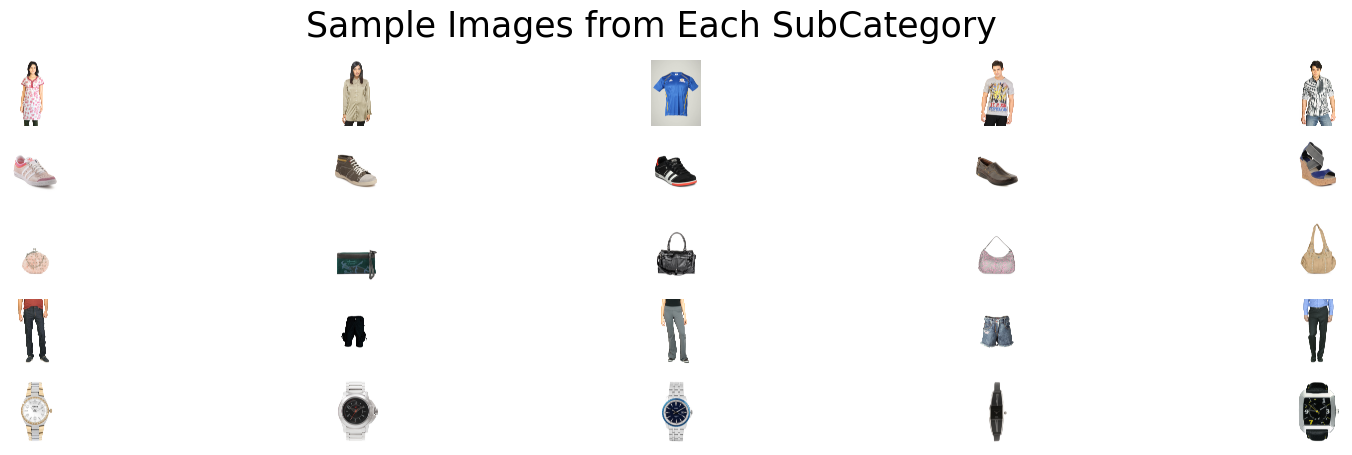

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import os

base_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
styles_df = df_styles
# Parameters
IMAGE_FOLDER = f"{base_path}/images"
top_n = 5  # number of images per subcategory
subcategories = ['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches']  # chosen for your project

plt.figure(figsize=(20, 5))

for i, subcat in enumerate(subcategories):
    sub_df = styles_df[styles_df['subCategory'] == subcat].sample(top_n, random_state=42)
    
    for j, row in enumerate(sub_df.itertuples()):
        plt.subplot(len(subcategories), top_n, i*top_n + j + 1)
        img_path = os.path.join(IMAGE_FOLDER, str(row.id) + ".jpg")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        if j == 0:
            plt.ylabel(subcat, fontsize=14)
plt.suptitle("Sample Images from Each SubCategory", fontsize=25)
plt.show()


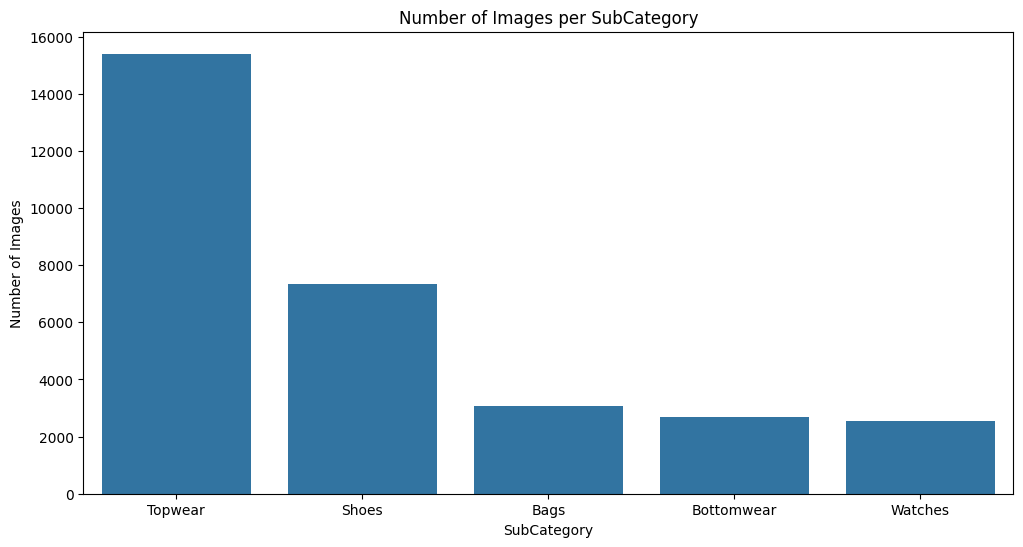

In [32]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=subcategories, y=[styles_df[styles_df['subCategory']==sc].shape[0] for sc in subcategories])
plt.title("Number of Images per SubCategory")
plt.ylabel("Number of Images")
plt.xlabel("SubCategory")
plt.show()


# Filtering Top Wear Articles 

In [33]:
topwear_df = styles_df[styles_df['subCategory'] == 'Topwear']


In [34]:
topwear_counts = topwear_df['articleType'].value_counts()
topwear_counts.head(10)  # show top 10 for sanity check


articleType
Tshirts        7066
Shirts         3217
Kurtas         1844
Tops           1762
Sweatshirts     285
Sweaters        277
Jackets         258
Kurtis          234
Tunics          229
Dupatta         116
Name: count, dtype: int64

/tmp/ipykernel_55/3208533472.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.index, y=top_10.values, palette="viridis")


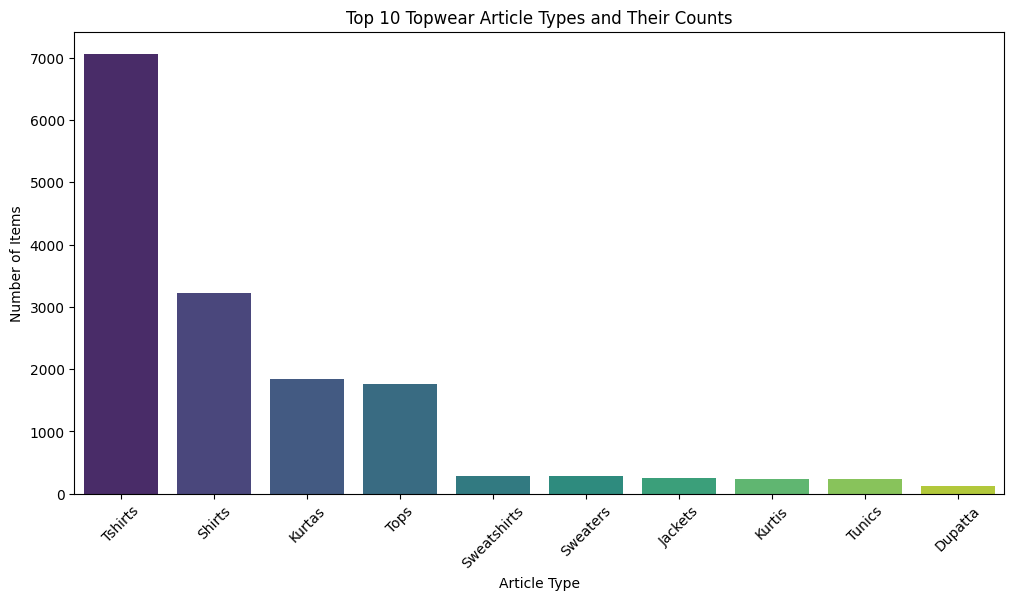

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take top 10 article types
top_10 = topwear_counts[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10.index, y=top_10.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Topwear Article Types and Their Counts")
plt.xlabel("Article Type")
plt.ylabel("Number of Items")
plt.show()


# Filtering Top Wear Articles with respect to 'Gender'

In [36]:
topwear_gender_counts = topwear_df.groupby(['articleType', 'gender']).size().reset_index(name='count')
topwear_gender_counts.head(10)


,articleType,gender,count
0,Belts,Men,3
1,Blazers,Boys,1
2,Blazers,Men,5
3,Blazers,Women,2
4,Dresses,Women,2
5,Dupatta,Women,116
6,Jackets,Boys,6
7,Jackets,Men,195
8,Jackets,Unisex,1
9,Jackets,Women,56


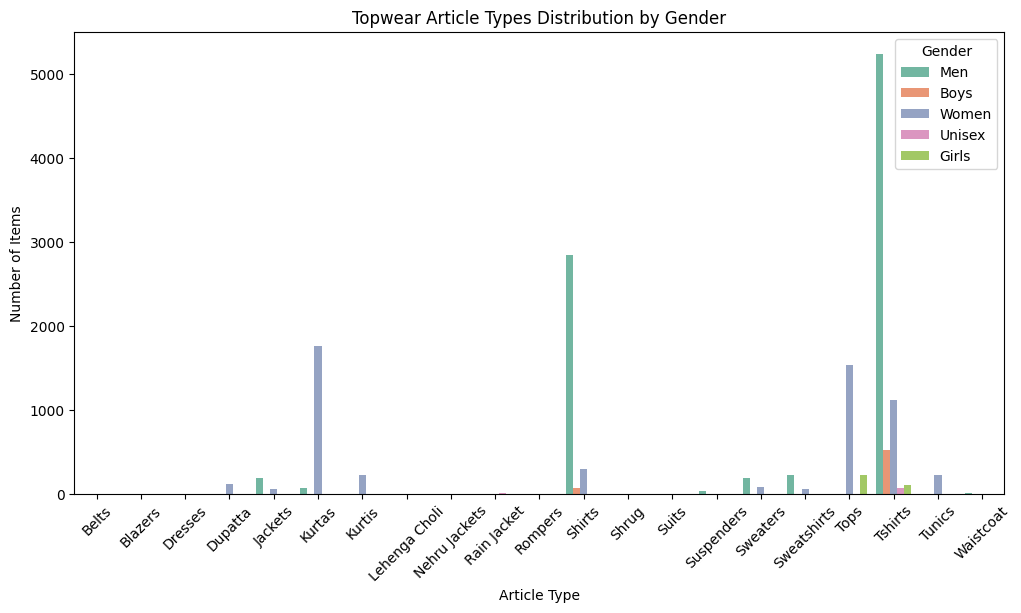

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=topwear_gender_counts, x='articleType', y='count', hue='gender', palette='Set2')
plt.xticks(rotation=45)
plt.title("Topwear Article Types Distribution by Gender")
plt.xlabel("Article Type")
plt.ylabel("Number of Items")
plt.legend(title='Gender')
plt.show()


# Train Test Validation Split
### Train 70% 
### Validation 15%
### Test 15%

In [38]:
from sklearn.model_selection import train_test_split

apparel_df = styles_df[
    styles_df['subCategory'].isin(['Topwear', 'Bottomwear'])
]

train_df, temp_df = train_test_split(
    apparel_df, test_size=0.3, stratify=apparel_df['subCategory'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['subCategory'], random_state=42
)


In [40]:
import pandas as pd

base_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"

styles_df = pd.read_csv(
    f"{base_path}/styles.csv",
    engine="python",
    on_bad_lines="skip"
)

print(styles_df.shape)
styles_df.head()



(44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [41]:
styles_df.columns


Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

# Remove Missing Id's 

In [42]:
styles_df.dropna(subset=['id'], inplace=True)
styles_df['id'] = styles_df['id'].astype(int)


# Filter only Topwear & Bottomwear

In [43]:
apparel_df = styles_df[
    styles_df['subCategory'].isin(['Topwear', 'Bottomwear'])
].copy()

label_map = {'Topwear': 0, 'Bottomwear': 1}
apparel_df['label'] = apparel_df['subCategory'].map(label_map)
apparel_df['image'] = apparel_df['id'].astype(str) + ".jpg"

apparel_df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,label,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,0,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,1,39386.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,1,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,0,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,0,1855.jpg


In [44]:
apparel_df['subCategory'].value_counts()


subCategory
Topwear       15402
Bottomwear     2694
Name: count, dtype: int64